In [1]:
# =============================================
# ANÁLISE DE EMOÇÕES NA VOZ - VERSÃO 3.1 FINAL
# Pipeline completo: de URLs a DataFrame Master Consolidado
# =============================================

import os
import yt_dlp
import whisper
import librosa
import soundfile as sf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import re
import csv 
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore", module="whisper")

# =============================================
# CONFIGURAÇÕES GLOBAIS
# =============================================
PASTA_DADOS = "dados"
PASTA_RESULTADOS = "resultados"
ARQUIVO_URLS = "urls.txt"

os.makedirs(PASTA_DADOS, exist_ok=True)
os.makedirs(PASTA_RESULTADOS, exist_ok=True)

# Listas globais para acumular resultados
todos_dfs_master = []  # AGORA: UM ÚNICO DATAFRAME MASTER COM TUDO

# =============================================
# FUNÇÃO: Extrair ID do Tweet da URL
# =============================================
def extrair_id_tweet(url):
    try:
        url = url.strip()
        padrao = r'/status/(\d+)'
        resultado = re.search(padrao, url)
        return resultado.group(1) if resultado else None
    except Exception as e:
        print(f"Erro ao extrair ID: {e}")
        return None

# =============================================
# FUNÇÃO: Baixar Vídeo do Twitter
# =============================================
def baixar_video_twitter(url, tweet_id):
    nome_video = f"video_{tweet_id}.mp4"
    caminho_video = os.path.join(PASTA_DADOS, nome_video)
    
    if os.path.exists(caminho_video):
        print(f" Vídeo já existe: {caminho_video}")
        return caminho_video

    ydl_opts = {
        'format': 'bestvideo+bestaudio/best',
        'outtmpl': caminho_video,
        'merge_output_format': 'mp4',
        'quiet': False,
    }

    try:
        print(f"Baixando vídeo do tweet {tweet_id}...")
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            ydl.download([url])
        print(f"Vídeo salvo: {caminho_video}")
        return caminho_video
    except Exception as e:
        print(f"Falha ao baixar vídeo: {e}")
        return None

# =============================================
# FUNÇÃO: Extrair Áudio do Vídeo
# =============================================
def extrair_audio(video_entrada, tweet_id):
    nome_audio = f"audio_{tweet_id}.wav"
    caminho_audio = os.path.join(PASTA_DADOS, nome_audio)
    
    if os.path.exists(caminho_audio):
        print(f"Áudio já existe: {caminho_audio}")
        return caminho_audio

    comando = f'ffmpeg -i "{video_entrada}" -vn -acodec pcm_s16le -ar 16000 -ac 1 "{caminho_audio}"'
    print(f"Executando: {comando}")
    
    if os.system(comando) == 0:
        print(f"Áudio extraído: {caminho_audio}")
        return caminho_audio
    else:
        print("Erro ao extrair áudio.")
        return None

# =============================================
# FUNÇÃO: Transcrever Áudio Completo (Whisper)
# =============================================
def transcrever_audio(caminho_audio, tweet_id, idioma="pt"):
    nome_txt = f"transcricao_completa_{tweet_id}.txt"
    caminho_txt = os.path.join(PASTA_DADOS, nome_txt)
    
    if os.path.exists(caminho_txt):
        print(f"Transcrição completa já existe: {caminho_txt}")
        with open(caminho_txt, "r", encoding="utf-8") as f:
            return {"text": f.read()}

    print("Carregando modelo Whisper (small)...")
    modelo = whisper.load_model("small")
    print("Transcrevendo áudio completo...")
    resultado = modelo.transcribe(caminho_audio, language=idioma)
    
    with open(caminho_txt, "w", encoding="utf-8") as f:
        f.write(resultado["text"])
    print(f"Transcrição completa salva: {caminho_txt}")
    return resultado

# =============================================
# FUNÇÃO: Calcular Sentimento Global (VADER)
# =============================================
def calcular_sentimento_global(texto):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(texto)

# =============================================
# FUNÇÃO: Analisar Trechos Emocionais + Consolidar com Global
# =============================================
def analisar_trechos_emocionais(caminho_audio, tweet_id, sentimento_global, duracao_trecho=4):
    """
    RETORNA UM DATAFRAME COM:
    - timestamp, trecho, emocao_voz, sentimento_texto, observacao
    - neg_trecho, neu_trecho, pos_trecho, compound_trecho
    - neg_global, neu_global, pos_global, compound_global
    - tweet_id
    """
    print(f" Analisando trechos emocionais do tweet {tweet_id}...")
    
    audio, sr = librosa.load(caminho_audio, sr=16000)
    duracao_total = len(audio) / sr

    modelo_whisper = whisper.load_model("small")
    emotion_classifier = pipeline("audio-classification", model="superb/wav2vec2-base-superb-er")
    analyzer = SentimentIntensityAnalyzer()

    dados_trechos = []
    inicio = 0

    while inicio < duracao_total:
        fim = min(inicio + duracao_trecho, duracao_total)
        inicio_sample = int(inicio * sr)
        fim_sample = int(fim * sr)
        trecho_audio = audio[inicio_sample:fim_sample]
        
        caminho_trecho = f"temp_trecho_{int(inicio)}.wav"
        sf.write(caminho_trecho, trecho_audio, sr)

        try:
            resultado = modelo_whisper.transcribe(caminho_trecho, language="pt")
            texto = resultado["text"].strip()

            if texto:
                # Emoção na voz
                emocao_result = emotion_classifier(caminho_trecho)
                emocao_top = max(emocao_result, key=lambda x: x['score'])
                
                # Sentimento do TRECHO
                sentimento_trecho = analyzer.polarity_scores(texto)
                
                # Observações
                observacao = ""
                if "!" in texto:
                    observacao += "gritou; "
                if "..." in texto or texto.endswith("?"):
                    observacao += "tom irônico/sarcástico; "
                if emocao_top['label'] == "hap" and "!" in texto:
                    observacao += "entusiasmo; "
                
                texto_lower = texto.lower()

                # Gritos / ênfase
                if texto.isupper() and len(texto) > 3:
                    observacao += "gritou com todas as letras; "
            
                # Repetições de pontuação
                if "!!!" in texto:
                    observacao += "ênfase extrema / surto emocional; "
                if "???" in texto:
                    observacao += "confusão ou desespero interrogativo; "
            
                # Palavras emocionais
                palavras_tristeza = ["choro", "triste", "sinto falta", "dói", "sozinho"]
                if any(palavra in texto_lower for palavra in palavras_tristeza):
                    observacao += "indícios de tristeza no texto; "
            
                palavras_raiva = ["odeio", "detesto", "absurdo", "ridículo", "inacreditável"]
                if any(palavra in texto_lower for palavra in palavras_raiva):
                    observacao += "indícios de raiva/indignação; "
            
                # Alongamentos (ex: "naaao", "ameiiii")
                import re
                if re.search(r'[aáeéiíoóuú]{3,}', texto_lower):
                    observacao += "alongamento emocional (ênfase afetiva); "
            
                # Ironia com aspas
                if '"' in texto or "''" in texto:
                    if "que" in texto_lower and ("bom" in texto_lower or "ótimo" in texto_lower or "maravilhoso" in texto_lower):
                        observacao += "possível ironia com elogio falso; "
            
                # Emojis (opcional, se aplicável)
                emojis_felizes = ["😀", "😁", "😂", "😍", "🥰", "🎉", "💖"]
                emojis_tristes = ["😢", "😭", "😞", "😔"]
                emojis_raiva = ["😡", "🤬", "👿"]
            
                if any(emoji in texto for emoji in emojis_felizes):
                    observacao += "emoji de alegria/entusiasmo; "
                if any(emoji in texto for emoji in emojis_tristes):
                    observacao += "emoji de tristeza; "
                if any(emoji in texto for emoji in emojis_raiva):
                    observacao += "emoji de raiva; "
            
                # Remover último "; " se houver
                if observacao.endswith("; "):
                    observacao = observacao[:-2]
            
                if not observacao:
                    observacao = "nenhuma observação"
                    
                timestamp = f"{int(inicio//60):02d}:{int(inicio%60):02d}"

                # MONTA LINHA COMPLETA PARA O DATAFRAME MASTER
                linha = {
                    "tweet_id": tweet_id,
                    "timestamp": timestamp,
                    "trecho": texto,
                    "emocao_voz": emocao_top['label'],
                    "sentimento_texto": "positivo" if sentimento_trecho['compound'] >= 0.05 else "negativo" if sentimento_trecho['compound'] <= -0.05 else "neutro",
                    "observacao": observacao.strip("; "),
                    # Scores do TRECHO
                    "neg_trecho": sentimento_trecho['neg'],
                    "neu_trecho": sentimento_trecho['neu'],
                    "pos_trecho": sentimento_trecho['pos'],
                    "compound_trecho": sentimento_trecho['compound'],
                    # Scores GLOBAIS (do tweet inteiro)
                    "neg_global": sentimento_global['neg'],
                    "neu_global": sentimento_global['neu'],
                    "pos_global": sentimento_global['pos'],
                    "compound_global": sentimento_global['compound']
                }
                dados_trechos.append(linha)

                print(f"[{timestamp}] {texto[:50]}... → {emocao_top['label']}, {linha['sentimento_texto']}")

        except Exception as e:
            print(f"Erro no trecho {inicio}-{fim}: {e}")
        finally:
            if os.path.exists(caminho_trecho):
                os.remove(caminho_trecho)

        inicio += duracao_trecho

    # Cria DataFrame
    df = pd.DataFrame(dados_trechos)
    if not df.empty:
        caminho_csv = os.path.join(PASTA_RESULTADOS, f"trechos_emocionais_{tweet_id}.csv")
        df.to_csv(caminho_csv, index=False, encoding="utf-8")
        print(f"DataFrame de trechos salvo: {caminho_csv}")
    else:
        print("Nenhum trecho com fala identificado.")
    
    return df

# =============================================
# FUNÇÃO: Gerar Gráfico Individual
# =============================================
def gerar_grafico_individual(tweet_id, caminho_audio, sentimento_global):
    emotion_classifier = pipeline("audio-classification", model="superb/wav2vec2-base-superb-er")
    resultado_emocao = emotion_classifier(caminho_audio)

    plt.figure(figsize=(12, 5))
    # Gráfico 1: Emoções na Voz
    # Cria um dicionário de mapeamento para os rótulos descritivos
    label_map = {
        'sad': 'Tristeza (sad)',
        'hap': 'Felicidade (hap)',
        'neu': 'Neutro (neu)',
        'ang': 'Raiva (ang)'
    }
    
    # Extrai labels e scores originais
    original_labels = [e['label'] for e in resultado_emocao]
    scores = [e['score'] for e in resultado_emocao]
    
    # Substitui pelos rótulos descritivos
    labels = [label_map.get(label, label) for label in original_labels]  # .get() evita erro se label não existir
    
    plt.subplot(1, 2, 1)
    bars = plt.bar(labels, scores, color='lightcoral', edgecolor='darkred')
    plt.title(f"Emoções na Voz - Tweet {tweet_id[-6:]}", fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Probabilidade')
    
    # (Opcional) Adiciona valores nas barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    # Gráfico 2: Sentimento Global
    plt.subplot(1, 2, 2)
    plt.bar(sentimento_global.keys(), sentimento_global.values(), color='lightblue', edgecolor='darkblue')
    plt.title(f"Sentimento Global - Tweet {tweet_id[-6:]}", fontweight='bold')
    plt.ylim(-1, 1)
    plt.ylabel('Score VADER')

    plt.tight_layout()
    caminho_grafico = os.path.join(PASTA_RESULTADOS, f"grafico_{tweet_id}.png")
    plt.savefig(caminho_grafico, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Gráfico individual salvo: {caminho_grafico}")

# =============================================
# FUNÇÃO: Processar 1 Tweet (fluxo completo)
# =============================================
def processar_tweet(url):
    print(f"\n{'='*60}")
    print(f"PROCESSANDO: {url}")
    print(f"{'='*60}")

    tweet_id = extrair_id_tweet(url)
    if not tweet_id:
        return False

    caminho_video = baixar_video_twitter(url, tweet_id)
    if not caminho_video:
        return False

    caminho_audio = extrair_audio(caminho_video, tweet_id)
    if not caminho_audio:
        return False

    resultado_transcricao = transcrever_audio(caminho_audio, tweet_id)
    if not resultado_transcricao:
        return False

    sentimento_global = calcular_sentimento_global(resultado_transcricao["text"])

    # ANALISA TRECHOS E RETORNA DATAFRAME COM TUDO
    df_trechos = analisar_trechos_emocionais(caminho_audio, tweet_id, sentimento_global, duracao_trecho=4)
    
    if not df_trechos.empty:
        todos_dfs_master.append(df_trechos)  # ACUMULA PARA O MASTER FINAL

    # Gera gráfico individual
    gerar_grafico_individual(tweet_id, caminho_audio, sentimento_global)

    print(f"\nTWEET {tweet_id} PROCESSADO COM SUCESSO!")
    return True

# =============================================
# FUNÇÃO: Gerar Gráficos Consolidados
# =============================================
def gerar_graficos_consolidados():
    if not todos_dfs_master:
        return

    df_master = pd.concat(todos_dfs_master, ignore_index=True)

    # Gráfico consolidado de sentimento global
    plt.figure(figsize=(14, 7))
    unique_tweets = df_master.drop_duplicates('tweet_id')
    bars = plt.bar(range(len(unique_tweets)), unique_tweets['compound_global'], color='lightgreen', edgecolor='darkgreen')
    plt.title("Sentimento Consolidado de Todos os Tweets (VADER - Compound Score)", fontweight='bold')
    plt.xlabel("Tweet ID (últimos 6 dígitos)")
    plt.ylabel("Compound Score")
    plt.xticks(range(len(unique_tweets)), unique_tweets['tweet_id'].str[-6:], rotation=45, ha='right')
    plt.axhline(0, color='black', linestyle='--')
    plt.grid(axis='y', alpha=0.7)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02 * (1 if height >=0 else -1),
                 f'{height:.2f}', ha='center', va='bottom' if height >=0 else 'top', fontsize=9)
    plt.tight_layout()
    plt.savefig(os.path.join(PASTA_RESULTADOS, "consolidado_sentimento_todos_tweets.png"), dpi=150, bbox_inches='tight')
    plt.show()
    print("Gráfico consolidado de sentimento salvo.")

# =============================================
# FUNÇÃO: Salvar DataFrame Master Consolidado
# =============================================
def salvar_dataframe_master():
    if not todos_dfs_master:
        print("Nenhum dado para salvar.")
        return

    df_master = pd.concat(todos_dfs_master, ignore_index=True)
    
    # Ordena colunas para melhor visualização
    colunas_ordem = [
        "tweet_id", "timestamp", "trecho", "emocao_voz", "sentimento_texto", "observacao",
        "neg_trecho", "neu_trecho", "pos_trecho", "compound_trecho",
        "neg_global", "neu_global", "pos_global", "compound_global"
    ]
    
    df_master = df_master[colunas_ordem]
    caminho_master = os.path.join(PASTA_RESULTADOS, "master_todos_trechos_consolidado.csv")
    
    # CORREÇÃO AQUI: Adiciona quoting e quotechar
    df_master.to_csv(
        caminho_master,
        index=False,
        encoding="utf-8",
        quoting=csv.QUOTE_NONNUMERIC,  # Coloca aspas em todos os campos NÃO numéricos
        quotechar='"'                  # Usa aspas duplas
    )
    
    print(f"\nDATAFRAME MASTER CONSOLIDADO SALVO EM: {caminho_master}")
    print(f"Total de trechos analisados: {len(df_master)}")
    print(f"Total de tweets: {df_master['tweet_id'].nunique()}")

    # Exibe amostra
    print("\nAmostra do DataFrame Master:")
    display(df_master.head())

# =============================================
# FUNÇÃO: Processar Lista de URLs
# =============================================
def processar_lista_urls(arquivo_urls):
    if not os.path.exists(arquivo_urls):
        print(f"Arquivo {arquivo_urls} não encontrado.")
        return

    with open(arquivo_urls, "r", encoding="utf-8") as f:
        urls = [line.strip() for line in f if line.strip() and not line.startswith("#")]

    print(f"\nINICIANDO PROCESSAMENTO DE {len(urls)} VÍDEOS...\n")
    sucesso = sum(processar_tweet(url) for url in urls)
    
    print(f"\n{'='*60}")
    print(f"RESUMO FINAL: {sucesso}/{len(urls)} vídeos processados com sucesso!")
    print(f"{'='*60}")

INICIANDO PIPELINE COMPLETO - VERSÃO 1

INICIANDO PROCESSAMENTO DE 20 VÍDEOS...


PROCESSANDO: https://x.com/acervoemidias/status/1966548742355488960
 Vídeo já existe: dados/video_1966548742355488960.mp4
Áudio já existe: dados/audio_1966548742355488960.wav
Transcrição completa já existe: dados/transcricao_completa_1966548742355488960.txt
 Analisando trechos emocionais do tweet 1966548742355488960...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Eu vou ficar puta, você já é puta, vaga a puta do ... → hap, neutro
[00:04] Eu não me arrependo de ter xingado ela querendo ca... → hap, neutro
[00:08] Acho que ela tem que respeitar a galera que está n... → hap, neutro
[00:12] Não, eu não quero. Não entendi o que você tem a ve... → hap, neutro
DataFrame de trechos salvo: resultados/trechos_emocionais_1966548742355488960.csv


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


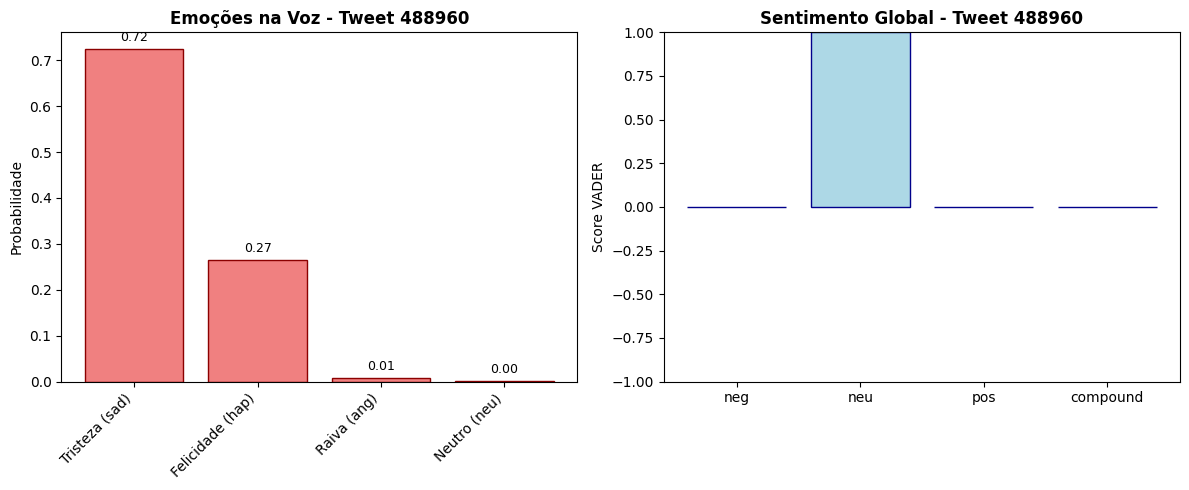

Gráfico individual salvo: resultados/grafico_1966548742355488960.png

TWEET 1966548742355488960 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/arc_maiana/status/1967094071681548768
 Vídeo já existe: dados/video_1967094071681548768.mp4
Áudio já existe: dados/audio_1967094071681548768.wav
Transcrição completa já existe: dados/transcricao_completa_1967094071681548768.txt
 Analisando trechos emocionais do tweet 1967094071681548768...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Cuckoo!... → hap, neutro
[00:04] 7 anos que eu fui comer pouca na primeira vez.... → sad, neutro
[00:08] Porque onde eu nasci? Não tinha dia...... → sad, neutro
[00:12] pra comprar pão nem tinha lugar pra comprar pão? É... → ang, neutro
[00:16] e o resto é fazer discurso. Mais cuidado!... → hap, neutro
[00:20] pobre de verdade você não cuida com a consciência ... → sad, neutro
[00:24] Bela cabeça e o coração.... → neu, neutro
[00:28] Você tem...... → hap, neutro
[00:32] Aqui você tem que defender aquilo.... → ang, positivo
[00:36] sentimento sobre aquilo. Ou ter por vida ou ter vi... → ang, neutro
[00:40] Eu te conheci de alguém que viveu aqui. Porque a v... → ang, neutro
[00:44] A fome não dói.... → sad, neutro
[00:48] ela vai corroindo você por dentro.... → ang, neutro
[00:52] que as pessoas têm vergonha de directa confondo.... → ang, neutro
[00:56] Eu vou cortar um caso meu.... → ang, neutro
[01:00] Eu fiquei desempregado no animeiro e mil novecento... → sad, negativo
[01:04

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


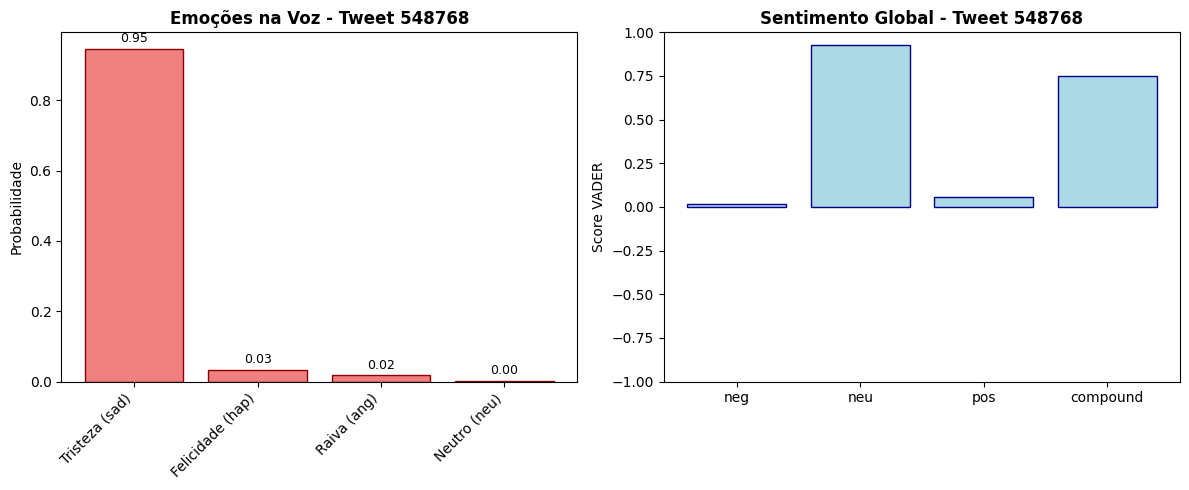

Gráfico individual salvo: resultados/grafico_1967094071681548768.png

TWEET 1967094071681548768 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/Ednaldo40916743/status/1967739931427778875
 Vídeo já existe: dados/video_1967739931427778875.mp4
Áudio já existe: dados/audio_1967739931427778875.wav
Transcrição completa já existe: dados/transcricao_completa_1967739931427778875.txt
 Analisando trechos emocionais do tweet 1967739931427778875...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Você não é vítima de sociedade, você é vítima da d... → hap, neutro
[00:04] Desculpe. E o papo ainda é de negócio desse nome.... → hap, neutro
[00:08] Eu não vou ficar assim! Eu não vou ficar assim!... → sad, neutro
[00:12] Já cadêそう! Macaretona!... → hap, neutro
[00:16] Mas deixa de tudo serТакio que você sente com a vi... → hap, neutro
[00:20] Eu nunca me torbido, mas adulto, você não é feito,... → sad, neutro
[00:24] Você é tarde, você é vídeo, mas a coisa é escondid... → hap, neutro
[00:28] Você tem pai, você tem mãe, uma família de estende... → hap, neutro
[00:32] Você fez sim! Você fez sim! Você fez sim! Você viu... → neu, neutro
[00:36] Eu acho que eu...... → hap, neutro
[00:40] errei assim, conhecesse de amor, eu acho que eu, p... → sad, positivo
[00:44] Ele sentiu falta disso. Mas...... → sad, neutro
[00:48] desespero quando entrei das delegacias porque me p... → sad, neutro
[00:52] Não é vítima da sociedade. Guarante tem pai, guara... → sad, neutro
[00:56] que me envo

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


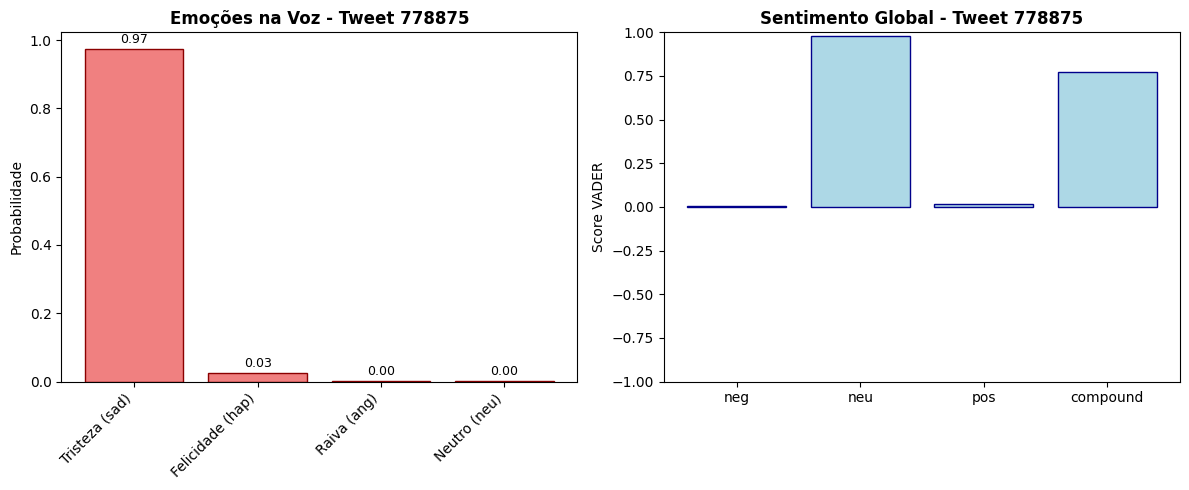

Gráfico individual salvo: resultados/grafico_1967739931427778875.png

TWEET 1967739931427778875 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/siteptbr/status/1967340478116065540
 Vídeo já existe: dados/video_1967340478116065540.mp4
Áudio já existe: dados/audio_1967340478116065540.wav
Transcrição completa já existe: dados/transcricao_completa_1967340478116065540.txt
 Analisando trechos emocionais do tweet 1967340478116065540...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Sabe como o diabo brinca comigo? Eu passei andando... → hap, neutro
[00:04] Gordo, me parou, eu falei, menina, você tá aí corr... → sad, neutro
[00:08] Olha, o mês que veio eu tô correndo também, não se... → sad, neutro
[00:12] No saco, ali o amigo dele. Aí eu voltei aqui...... → sad, negativo
[00:16] estão ali, está vendo? estou comprando o que é din... → sad, neutro
[00:20] com a chave, com tudo. Oi!... → hap, neutro
[00:24] Olha que seu pegar isso aí com a mina! Ele está ol... → hap, neutro
[00:28] Se eu pegar isso ai correndo... → hap, neutro
[00:32] Ha ha ha! Autário! Ele tá ali, né?... → hap, positivo
[00:36] Na praia ele está me chamando. Eu estou aqui escon... → hap, neutro
[00:40] O meu carro era só. Só um ól.... → sad, neutro
[00:44] E aí, ele me perturbando, né?... → sad, neutro
[00:56] para deixar de chão saco, viu?... → hap, neutro
[01:00] esse otário... → hap, neutro
[01:04] Pedras batam e eu fui... → hap, neutro
[01:08] O melhor de tudo é que está bem o amigo del

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


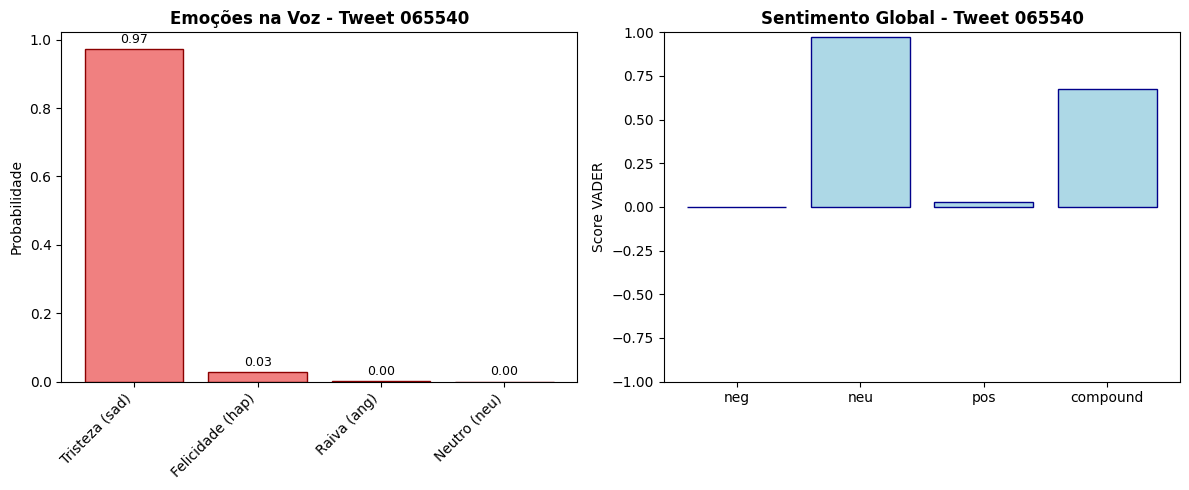

Gráfico individual salvo: resultados/grafico_1967340478116065540.png

TWEET 1967340478116065540 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/lucaspavanato/status/1967726428927193324
 Vídeo já existe: dados/video_1967726428927193324.mp4
Áudio já existe: dados/audio_1967726428927193324.wav
Transcrição completa já existe: dados/transcricao_completa_1967726428927193324.txt
 Analisando trechos emocionais do tweet 1967726428927193324...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Você vai fornecer informação? Se tiver que te most... → hap, negativo
[00:04] Ok, vamos chamar de sempre. Eu posso filmar? Posso... → hap, neutro
[00:08] para a gente eu vou chamar de ECM, porque eu tenho... → hap, neutro
[00:12] Eu estou fiscalizando a prefeitura, obviamente a p... → hap, neutro
[00:16] para defender a população.... → hap, positivo
[00:20] na UBS e opas de medicamentos que estão em falta. ... → neu, neutro
[00:24] medicamentos que estão faltando é pra ajudar vocês... → hap, neutro
[00:28] Ah, tem sim. Agora eu não quero ficar nesse debate... → ang, neutro
[00:32] faltando. De acordo com o sistema de vocês, você d... → ang, neutro
[00:36] mas não é só esses, eu quero todos que estão falta... → ang, neutro
[00:40] Então, é isso que eu preciso. Eu quero saber quais... → ang, neutro
[00:44] Eu já falei que eu não vou ter uma visão. Tá, você... → ang, neutro
[00:48] Você não vai fornecer informação? É crime? Pode ac... → hap, negativo
[00:52] os medicamentos que es

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


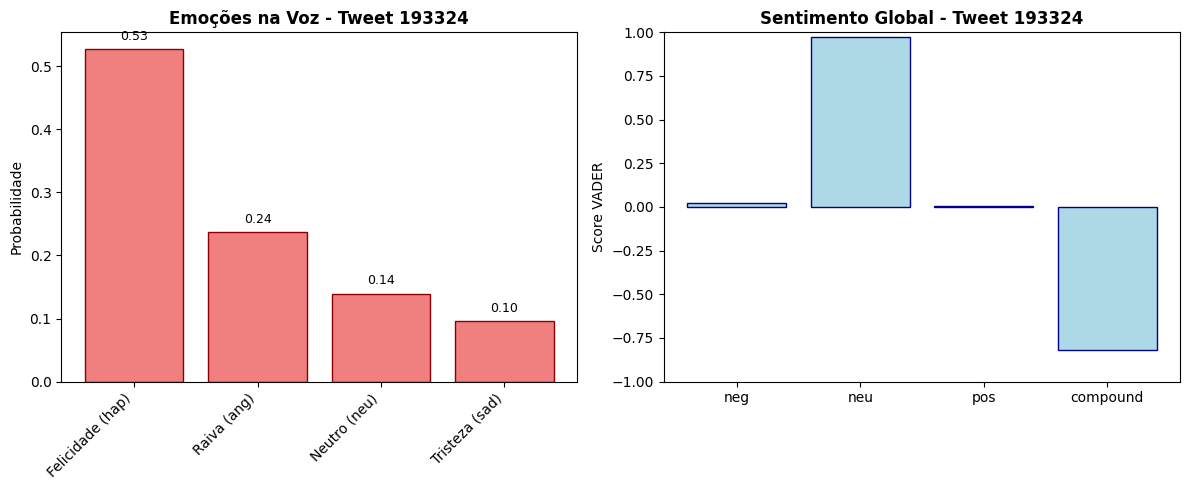

Gráfico individual salvo: resultados/grafico_1967726428927193324.png

TWEET 1967726428927193324 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/luuviisa/status/1967693349583982881
 Vídeo já existe: dados/video_1967693349583982881.mp4
Áudio já existe: dados/audio_1967693349583982881.wav
Transcrição completa já existe: dados/transcricao_completa_1967693349583982881.txt
 Analisando trechos emocionais do tweet 1967693349583982881...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Fala do eu? É, fala do tu. Gente, olha o que meu p... → hap, neutro
[00:04] o gosto dele. Alexia, hora do amor!... → hap, positivo
[00:08] Uau! Hora do amor.... → ang, positivo
[00:12] Que lindo! Sou o Vinte e Cinquenta e Três.... → ang, neutro
[00:16] Gata, se prepare para os melhores...... → ang, neutro
[00:20] dois minutos da sua vida. Com sorte talvez três.... → ang, neutro
[00:28] Aproveite os links Que deligada eu... → hap, neutro
[00:32] E olha lá, o melhor de tudo!... → hap, neutro
DataFrame de trechos salvo: resultados/trechos_emocionais_1967693349583982881.csv


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


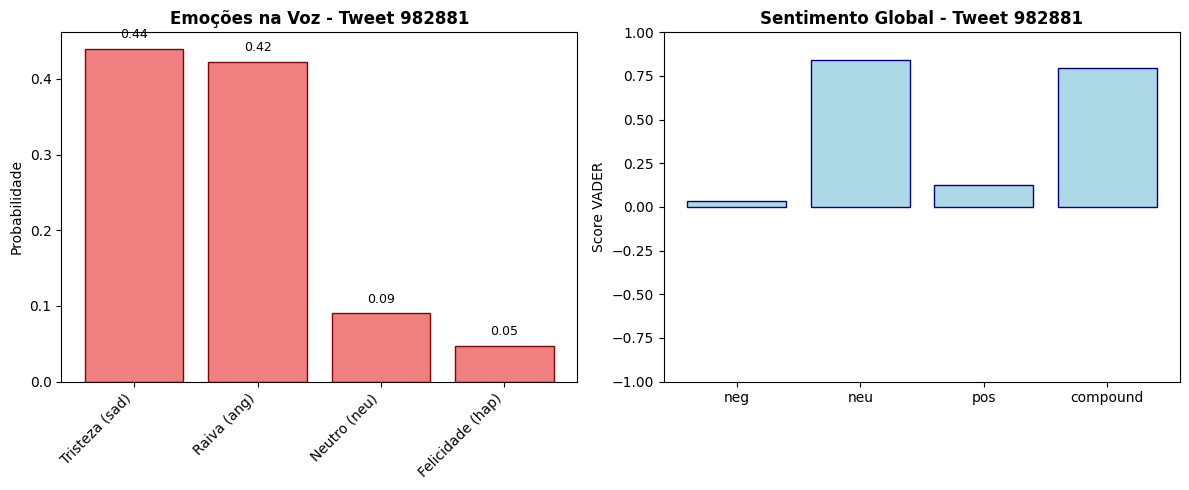

Gráfico individual salvo: resultados/grafico_1967693349583982881.png

TWEET 1967693349583982881 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/ricardogjunior/status/1965475295160414253
 Vídeo já existe: dados/video_1965475295160414253.mp4
Áudio já existe: dados/audio_1965475295160414253.wav
Transcrição completa já existe: dados/transcricao_completa_1965475295160414253.txt
 Analisando trechos emocionais do tweet 1965475295160414253...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Vamos lá!! Jorge eu그렇 Bright's todas tão felizes!!... → hap, neutro
[00:04] 播 o vídeo saber de... → ang, neutro
[00:08] 10 reais, não fica. Não! 10 reais!... → ang, neutro
[00:12] Não, filho da foda do vento, não ia dar R$ 100 a 1... → ang, neutro
[00:16] D soft voice... → ang, neutro
[00:24] Fala do dente e já tá bem, botão de noite.... → hap, neutro
DataFrame de trechos salvo: resultados/trechos_emocionais_1965475295160414253.csv


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


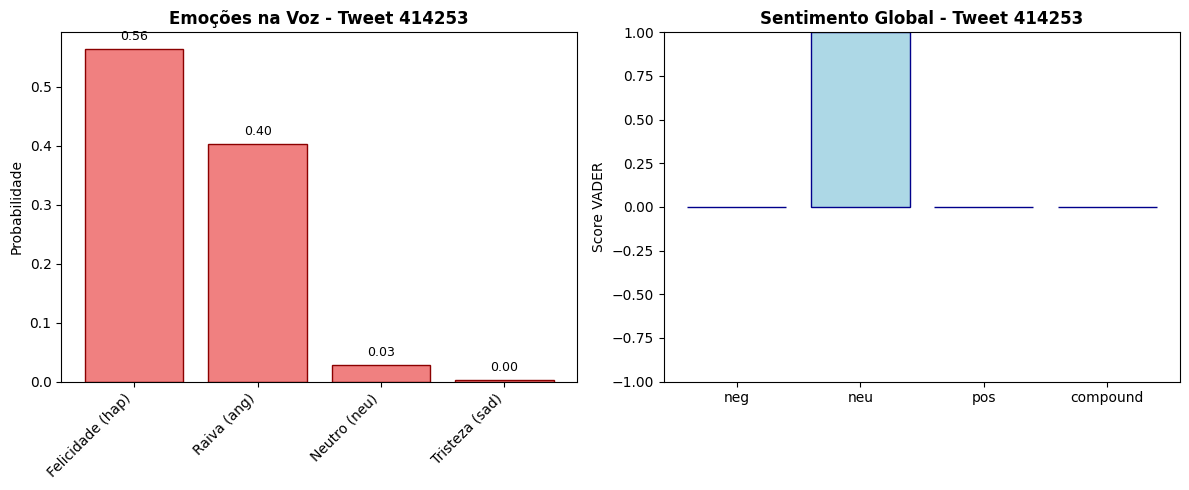

Gráfico individual salvo: resultados/grafico_1965475295160414253.png

TWEET 1965475295160414253 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/ricardogjunior/status/1967367438883823724
 Vídeo já existe: dados/video_1967367438883823724.mp4
Áudio já existe: dados/audio_1967367438883823724.wav
Transcrição completa já existe: dados/transcricao_completa_1967367438883823724.txt
 Analisando trechos emocionais do tweet 1967367438883823724...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Eu também que eu aponhava mas com o tio...... → ang, neutro
[00:04] Já pegava ontem? E agora?... → ang, neutro
[00:08] presetada para Airsoft para Shot Palace... → hap, neutro
[00:12] Jogi isso e me salvou. Sério? Aprendeu a latir?... → hap, neutro
[00:16] E aí? Eu alhopei, aprendi para ter?... → neu, neutro
[00:20] Ninguém agora nessa casa não mexe comigo.... → sad, neutro
[00:24] Eu vou bater. Você deve defender! Você deve defend... → hap, positivo
[00:28] e até vai na porrada também.... → hap, neutro
DataFrame de trechos salvo: resultados/trechos_emocionais_1967367438883823724.csv


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


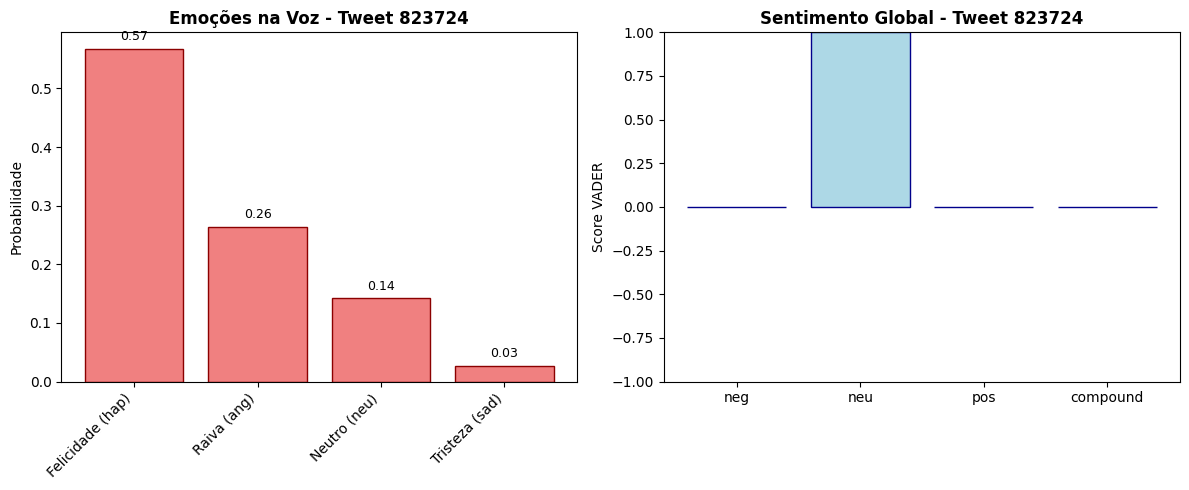

Gráfico individual salvo: resultados/grafico_1967367438883823724.png

TWEET 1967367438883823724 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/FlaviaMSoares76/status/1967375442710770113
 Vídeo já existe: dados/video_1967375442710770113.mp4
Áudio já existe: dados/audio_1967375442710770113.wav
Transcrição completa já existe: dados/transcricao_completa_1967375442710770113.txt
 Analisando trechos emocionais do tweet 1967375442710770113...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Esse menino de 5 anos falou que muita gente grande... → hap, neutro
[00:04] está fazendo.... → sad, neutro
[00:08] Deus. É? Sim. E o que você?... → hap, neutro
[00:12] Gostaria de falar para quem não conhece.... → hap, neutro
[00:16] e às vezes até fala mal da rossa. Fala mal?... → hap, neutro
[00:20] Você sabia que tem pessoas que falam mal da Rossa?... → hap, neutro
[00:24] mas ele falou nada porque mal sabia que o nosso ma... → hap, neutro
[00:28] O que é o maior orgulho? É plantar rósia e dividir... → sad, neutro
[00:32] com todos os pessoal do planeta Terra. Você sente ... → hap, neutro
[00:36] isso? Isso é chamado de produtor rural.... → hap, neutro
[00:40] Você falaria sobre a vida no campo? Aqui é a vida ... → hap, negativo
[00:44] A gente sente a presença de Deus, porque Deus aqui... → hap, neutro
[00:48] Muito bom para a gente. Cada pedacinho de degeniza... → sad, neutro
[00:52] pedacinho de Deus. Tem germinação de viaje...... → sad, neutro
[00:56] A gente produz alim

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


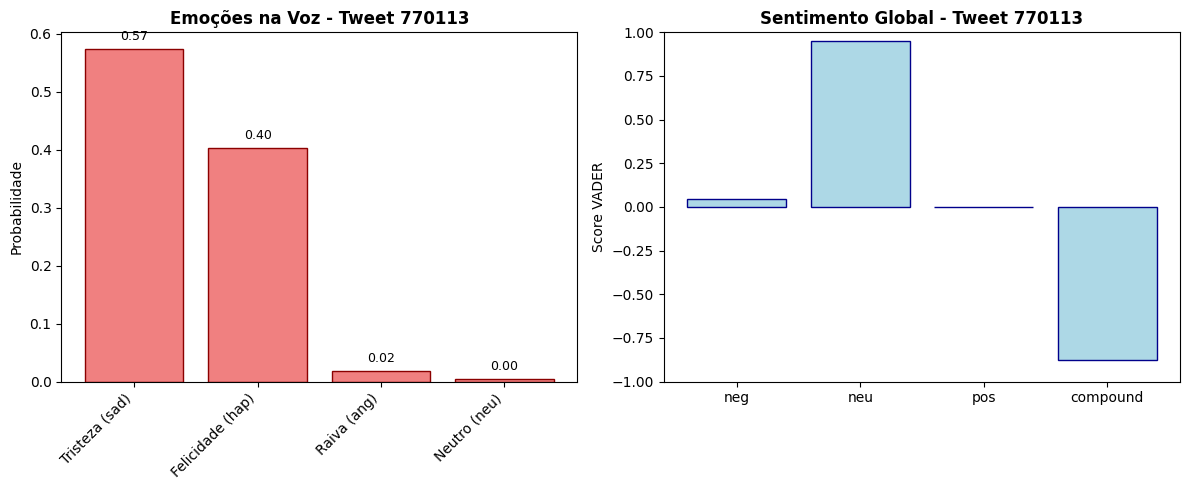

Gráfico individual salvo: resultados/grafico_1967375442710770113.png

TWEET 1967375442710770113 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/ItaloMarsinho/status/1967620231058342248
 Vídeo já existe: dados/video_1967620231058342248.mp4
Áudio já existe: dados/audio_1967620231058342248.wav
Transcrição completa já existe: dados/transcricao_completa_1967620231058342248.txt
 Analisando trechos emocionais do tweet 1967620231058342248...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Agora por favor, por favor, acorda! É, pago cara!... → sad, positivo
[00:04] Você não pagou, pague por favor.... → sad, positivo
[00:12] ... banana!... → sad, neutro
[00:20] Para, rapá! Evita confusão! Evita confusão! Pago r... → hap, neutro
[00:24] customize... → hap, neutro
[00:28] É reporte, paga o cara! Faliza!... → hap, neutro
DataFrame de trechos salvo: resultados/trechos_emocionais_1967620231058342248.csv


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


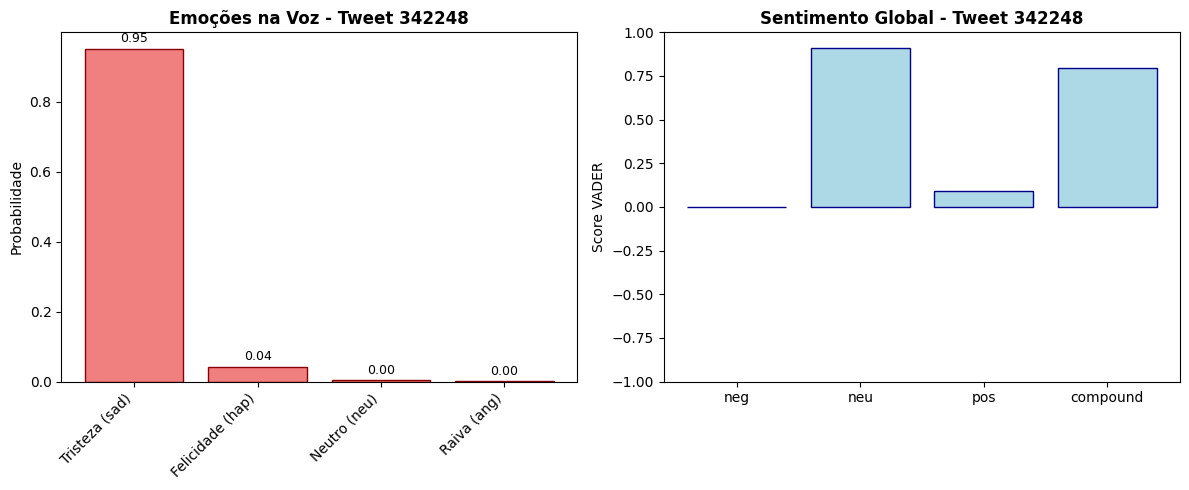

Gráfico individual salvo: resultados/grafico_1967620231058342248.png

TWEET 1967620231058342248 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/choquei/status/1967638210580038061
 Vídeo já existe: dados/video_1967638210580038061.mp4
Áudio já existe: dados/audio_1967638210580038061.wav
Transcrição completa já existe: dados/transcricao_completa_1967638210580038061.txt
 Analisando trechos emocionais do tweet 1967638210580038061...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Gosto? Ficou bom? Sim, demais!... → hap, neutro
[00:04] Tem bastante então. Aproveite.... → hap, neutro
[00:08] Eu e também a sua última refeição.... → hap, neutro
[00:12] Aproveita bem a sua última refeição.... → ang, neutro
[00:16] Como assim?... → neu, neutro
[00:20] e feita bem a sua última refeição.... → hap, neutro
[00:28] Por que você tá falando isso? Porque eu fiz especi... → hap, neutro
[00:32] Tudo? Não, meio que eu. Não quero só assistir você... → sad, neutro
[00:36] Pernanda, pelo amor de Deus, por que está falando ... → hap, positivo
[00:40] Brinda, eu não quero, eu não quero não, Brinda. O ... → sad, neutro
[00:44] Come tudo. Me dá pra uma guardideu. O que foi? O q... → sad, neutro
[00:48] comida que se colocou aqui brilho da pés amor de d... → hap, positivo
[00:52] Amor, o que que eu fiz? O que que eu fiz? Eu não f... → hap, positivo
[00:56] Aproveita bem que sou de previção.... → sad, neutro
[01:00] Pelo amor de Deus, o que você fez? Pelo amor de De... → sad, po

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


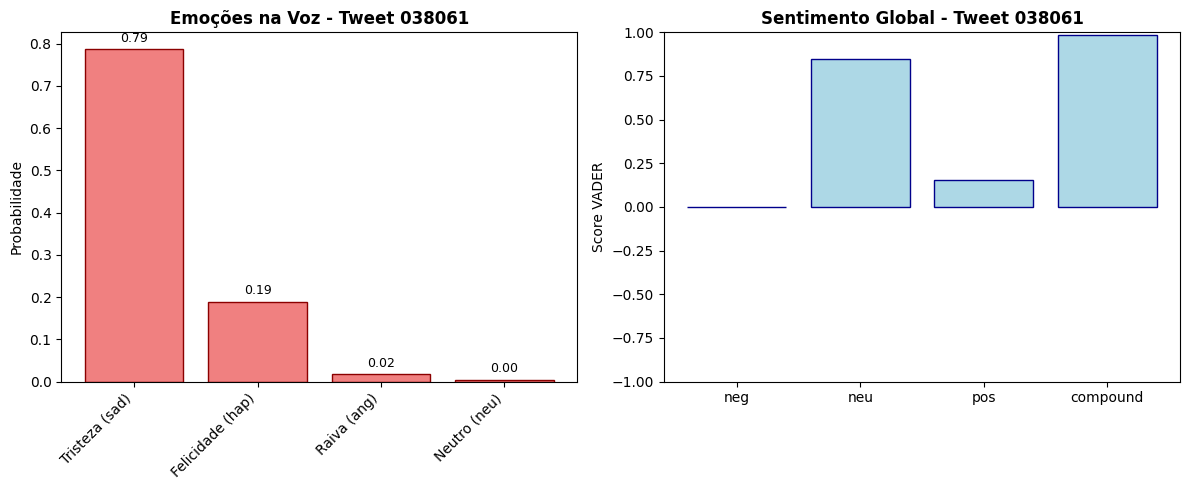

Gráfico individual salvo: resultados/grafico_1967638210580038061.png

TWEET 1967638210580038061 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/nonoinvestidor/status/1964742266385469886
 Vídeo já existe: dados/video_1964742266385469886.mp4
Áudio já existe: dados/audio_1964742266385469886.wav
Transcrição completa já existe: dados/transcricao_completa_1964742266385469886.txt
 Analisando trechos emocionais do tweet 1964742266385469886...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] mandar um beijo aí meu cachorro que ele está vendo... → hap, neutro
[00:04] alimenta carraçãozinha top, que é a raça nossa mes... → neu, positivo
[00:08] Aparada mesmo. Qual é o nome da ração? Ração Nice.... → ang, positivo
[00:12] Gêam, o coop is very nice.... → ang, positivo
[00:16] Bem buracinho!... → hap, neutro
[00:20] O que é? É nóis!... → neu, neutro
[00:28] Vai ter um atrás da outra.... → hap, neutro
[00:32] De apexa em frost... → hap, neutro
[00:44] O que aconteceu com seu olho? Só que foi uma...... → hap, neutro
[00:48] a treta, a na febem. Aí tinha um moleque que tomav... → hap, neutro
[00:52] ingerccoli, porque não é grande. Paranela... Serやっ... → hap, neutro
[00:56] Aaaaaah! Aaaaaah!... → hap, neutro
[01:00] Não dá para acala follow... → hap, neutro
[01:04] Minaura... → hap, neutro
[01:08] Ah, eu tô quase fazendo um corpo lá!... → hap, neutro
DataFrame de trechos salvo: resultados/trechos_emocionais_1964742266385469886.csv


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


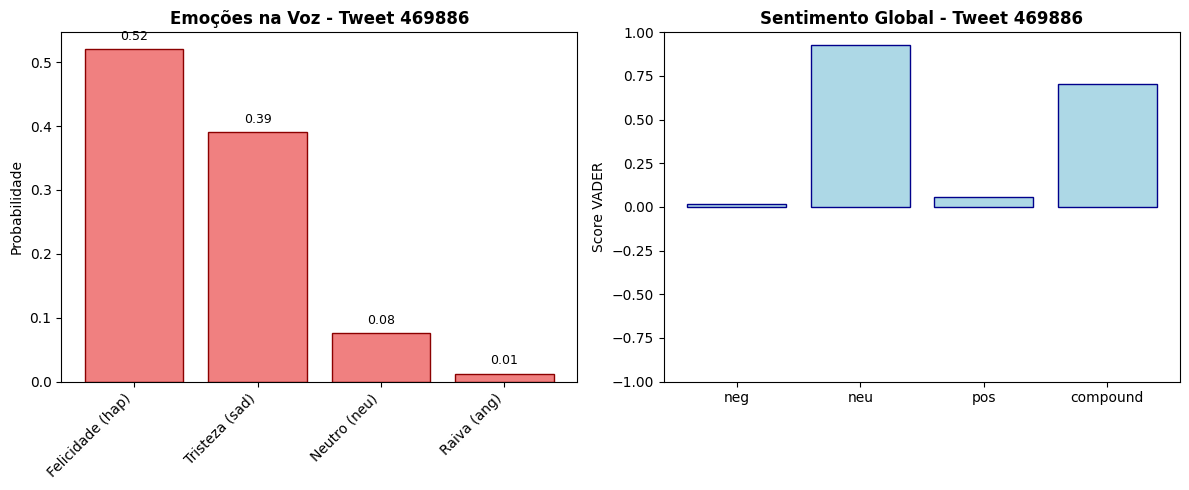

Gráfico individual salvo: resultados/grafico_1964742266385469886.png

TWEET 1964742266385469886 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/AnexoBRL/status/1967040590433914978
 Vídeo já existe: dados/video_1967040590433914978.mp4
Áudio já existe: dados/audio_1967040590433914978.wav
Transcrição completa já existe: dados/transcricao_completa_1967040590433914978.txt
 Analisando trechos emocionais do tweet 1967040590433914978...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] O meu greco!... → hap, neutro
[00:04] Aqui a doutora aqui ó, a doutora falou... → sad, neutro
[00:08] que não tem como ajudar a minha esposa. Aqui a dou... → sad, neutro
[00:12] A doutora não tem como... Vai fechar a...... → ang, neutro
[00:16] Vai fechar a torre! Me esposa caralho!... → hap, neutro
[00:20] Me esforza, porra! Porra, chama a política!... → ang, neutro
[00:24] Jama a minha esposa! É a minha esposa, caralho!... → hap, neutro
[00:28] Tá perdendo seu filho, porra! Porra!... → sad, neutro
[00:32] Doha! Fique forte, Calar! Doha!... → hap, neutro
[00:40] Eu tô na Upa, cheguei lá, pô, esporra! Eu tô na Up... → hap, neutro
[00:44] Eu estou aqui ó! Não tem como ajudar me esforçar!... → hap, neutro
[00:48] Tem como achutar isso... → hap, neutro
[00:52] Ela está perdendo meu filho!... → hap, neutro
[00:56] Ela tá perdendo a minha fila!... → hap, neutro
[01:00] Dansada!!! Personrendo est nets... → hap, neutro
[01:04] Meu filho! Você que não mais você é um pai!... → hap, neut

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


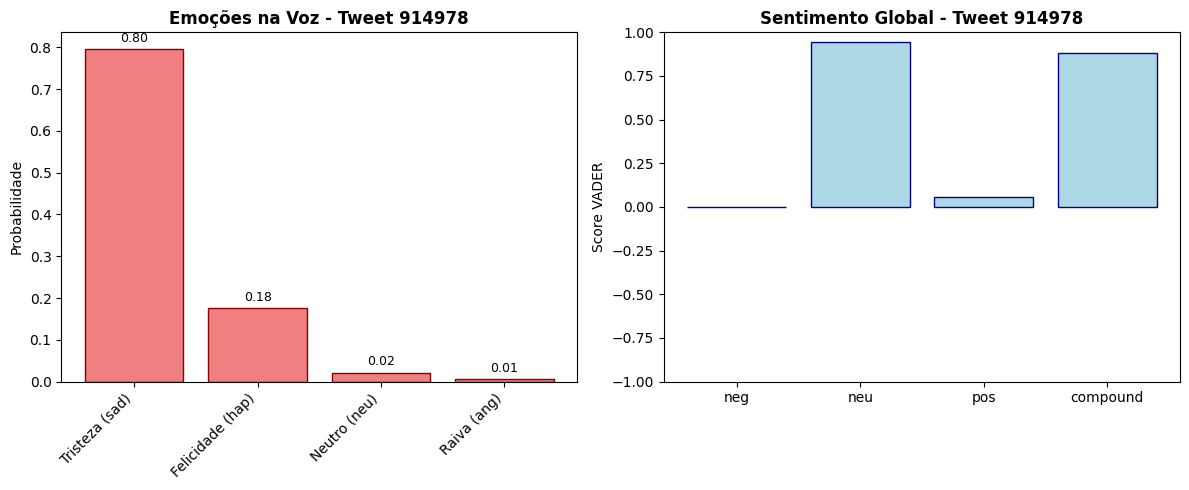

Gráfico individual salvo: resultados/grafico_1967040590433914978.png

TWEET 1967040590433914978 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/Metropoles/status/1967571157223149599
 Vídeo já existe: dados/video_1967571157223149599.mp4
Áudio já existe: dados/audio_1967571157223149599.wav
Transcrição completa já existe: dados/transcricao_completa_1967571157223149599.txt
 Analisando trechos emocionais do tweet 1967571157223149599...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] recebemos aqui no nosso instituto uma macaquinha p... → neu, negativo
[00:04] costas. O projeto atingiu a coluna. Ela foi examin... → hap, neutro
[00:08] nada, teve seu material biológico colhido para faz... → hap, neutro
[00:12] que também recebeu ampla medicação contra dor. No ... → hap, negativo
[00:16] o que parece ela perdeu o movimento das pernas não... → hap, neutro
[00:20] ao exame que checa sua condição de reflexo.... → hap, neutro
[00:24] Agora são para fazermos a tomografia e outros exam... → neu, neutro
[00:28] certeza se esse quadro é irreversível ou não.... → neu, neutro
[00:32] cruel nos quais os nossos animais silvestres são v... → hap, negativo
[00:36] sociedade. Essa é a Maria, uma macaquinha prego qu... → ang, neutro
[00:40] Ela passou pelos 5 anos exames de imagem, a ultras... → neu, neutro
[00:44] também que é a radiografia, onde a gente pode ver ... → hap, neutro
[00:48] o objeto na coluna dela. Ela está sem o movimento ... → hap, neutro
[00:52] agora é pa

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


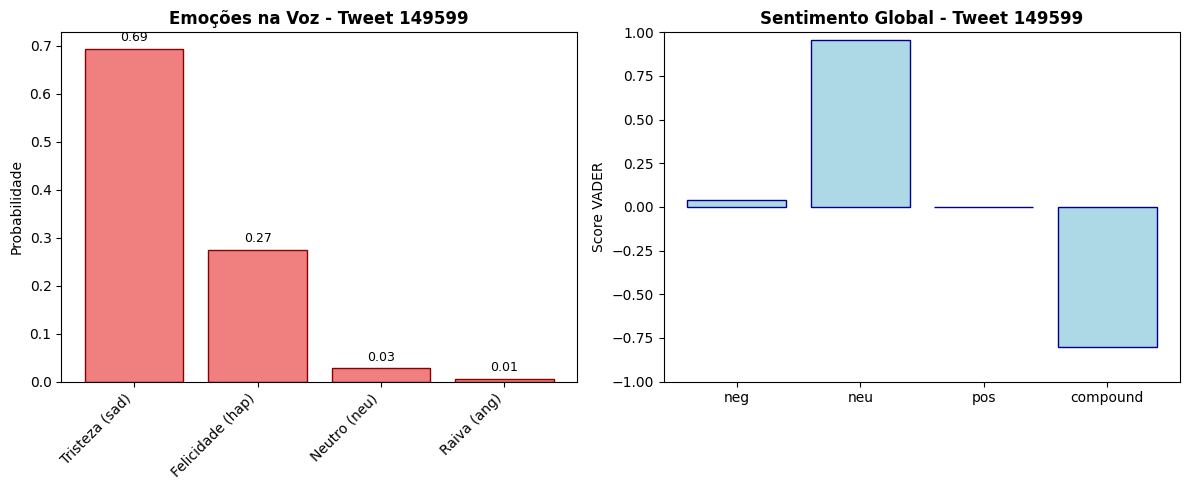

Gráfico individual salvo: resultados/grafico_1967571157223149599.png

TWEET 1967571157223149599 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/Ednaldo40916743/status/1967779141203398915
 Vídeo já existe: dados/video_1967779141203398915.mp4
Áudio já existe: dados/audio_1967779141203398915.wav
Transcrição completa já existe: dados/transcricao_completa_1967779141203398915.txt
 Analisando trechos emocionais do tweet 1967779141203398915...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] A minha porta... → sad, neutro
[00:04] Pô, amigo, pô, irmão sem camisa, irmão. Vamo mocar... → hap, neutro
[00:08] mas aí não dá véi como acaba?... → sad, neutro
[00:12] por vinte e sessão a casa por não, eu vou mandar m... → hap, neutro
[00:16] porque meu banco aí fica todo suado aí... → sad, neutro
[00:20] vai ficar tranquilo. Então tranquilo já, tô tranqu... → sad, neutro
[00:24] Eu estou na paz. Se você está básica aí irmão.... → sad, neutro
[00:28] screwed... → sad, negativo
[00:32] Não é a polícia não, né? E eu também, não?... → sad, neutro
[00:36] E aí filho pra caraca sim! O senhor tá parado! Mas... → sad, neutro
[00:40] Eu vi aqui que não endereça aqui, é Rua B... → sad, neutro
[00:44] O-A-C-L não é numeração eletra, por que?... → sad, neutro
[00:48] Eu vou-se lhe atrapar para você o que eu sou. C-R.... → sad, neutro
[00:52] E eu sou cria, pode ficar tranquilo que tá comigo.... → hap, neutro
[00:56] Mas é diferente, você tá?... → hap, neutro
[01:00] Então é comunidade 

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


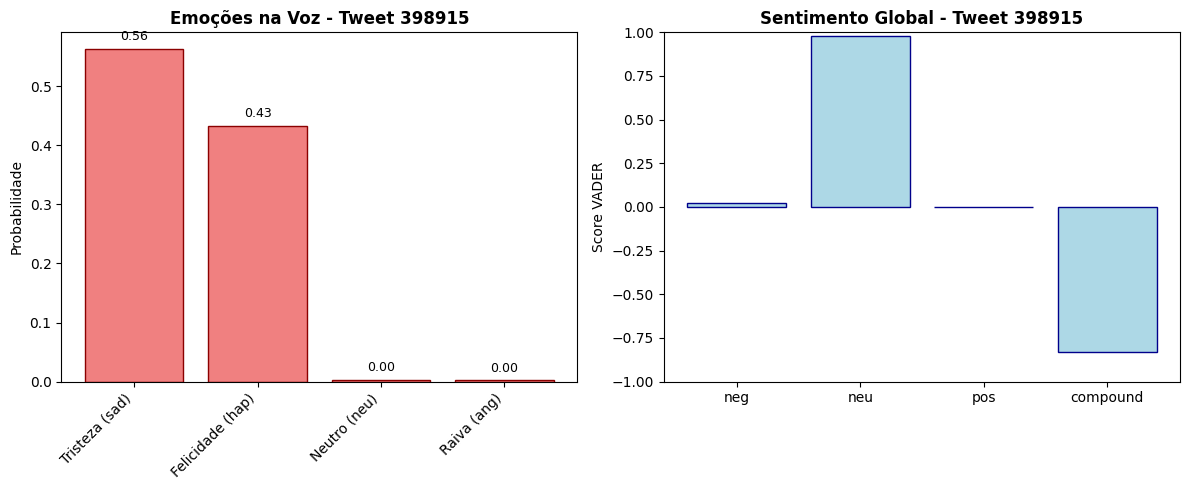

Gráfico individual salvo: resultados/grafico_1967779141203398915.png

TWEET 1967779141203398915 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/TumultoBR/status/1967680942291685420
 Vídeo já existe: dados/video_1967680942291685420.mp4
Áudio já existe: dados/audio_1967680942291685420.wav
Transcrição completa já existe: dados/transcricao_completa_1967680942291685420.txt
 Analisando trechos emocionais do tweet 1967680942291685420...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] stigma... → hap, neutro
[00:04] Sendo caducado, sendo casal, louco, louco!... → hap, neutro
[00:08] O que me vertigo? Tá com cagadeira, fica lá dentro... → hap, neutro
[00:12] Não tem coragem falar. Ó, to aqui dentro!... → hap, neutro
[00:16] Já estou indo atender, louco bebé chido!... → hap, neutro
[00:20] eh logo очерendinha se ouve... → hap, neutro
[00:24] É, é, é, gente, tá achando o seu... O seu...... → hap, neutro
[00:28] Eu estou com todo bombadão achando que é um bonito... → ang, neutro
[00:32] Não, não, não. Já tem chance, não. Tem chance, não... → hap, positivo
[00:36] bem feita é o botão de aqui a todo mundo... → ang, neutro
[00:40] Duches?... → hap, neutro
[00:44] Sua cara! Oh, algum? Todo mundo que é essa sua car... → hap, neutro
[00:48] Não é bonitao? Oh, gostosão!... → hap, neutro
[00:52] Né, bonitão? Ixi! Você...... → hap, neutro
[00:56] O pedaço é dessa banheira!... → hap, neutro
[01:00] E para a internet agora, não é bom? Vai estar roub... → hap, neutro
[01:04

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


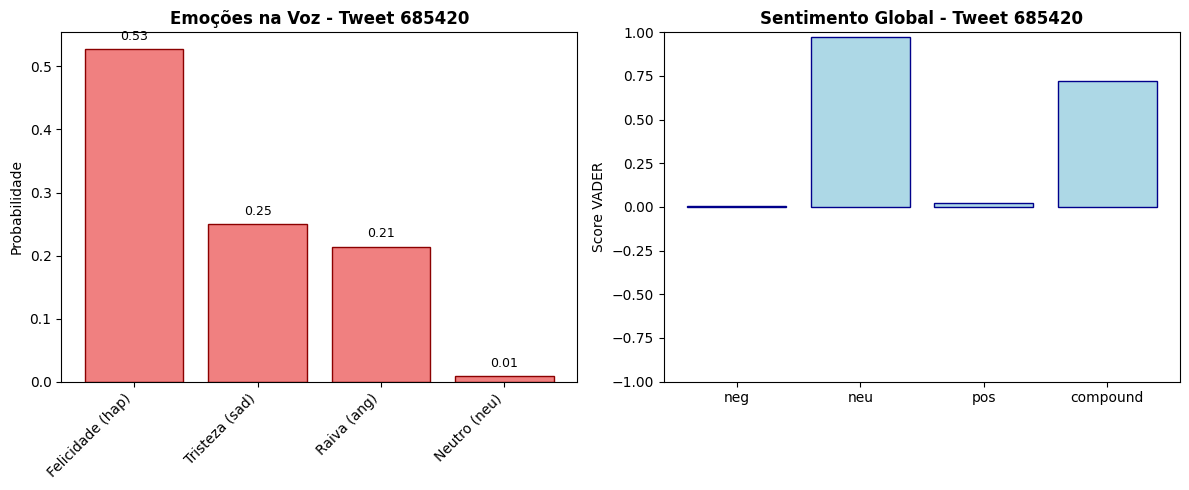

Gráfico individual salvo: resultados/grafico_1967680942291685420.png

TWEET 1967680942291685420 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/RenanSantosMBL/status/1967757912752955846
 Vídeo já existe: dados/video_1967757912752955846.mp4
Áudio já existe: dados/audio_1967757912752955846.wav
Transcrição completa já existe: dados/transcricao_completa_1967757912752955846.txt
 Analisando trechos emocionais do tweet 1967757912752955846...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Mataram agora a sangue frio na cidade praia grande... → ang, neutro
[00:04] Fondos. Rui Ferras Fondos foi delegado geral da Po... → ang, neutro
[00:08] São Paulo durante a prisão de Marcola, líder do PC... → ang, neutro
[00:12] secretário na área de segurança durante o governo ... → neu, neutro
[00:16] Praia Grande, uma cidade infestada pelo PCC, prime... → ang, neutro
[00:20] Rui, como vocês podem ver, estava fugindo no meio ... → ang, negativo
[00:24] o PCC que estava precisando do ele de carro, não c... → ang, neutro
[00:28] um ônibus e aí ele foi como vocês podem ver alvo d... → neu, neutro
[00:32] sangue frio. Não importa se a razão é porque ele p... → ang, neutro
[00:36] Marcola ou porque ele estava toando contra o P.C. ... → ang, neutro
[00:40] muito simples, o PCC e o Comando Vermelho demonstr... → ang, neutro
[00:44] já não narco estado. Não é uma situação natural. Q... → ang, positivo
[00:48] normalidade como os nossos governadores ou com o a... → ang, neutro
[00:52] 

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


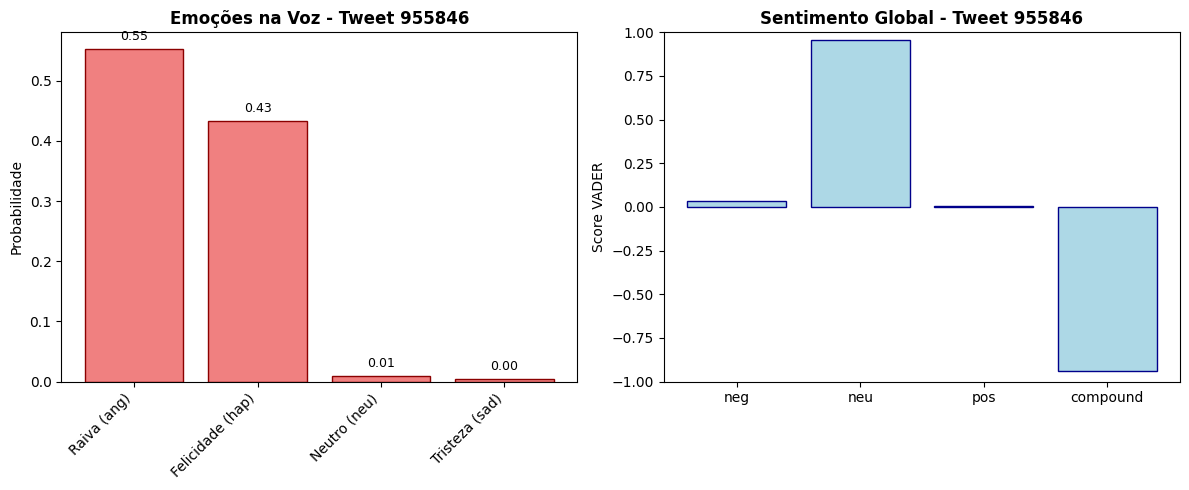

Gráfico individual salvo: resultados/grafico_1967757912752955846.png

TWEET 1967757912752955846 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/Metropoles/status/1967645400300478683
 Vídeo já existe: dados/video_1967645400300478683.mp4
Áudio já existe: dados/audio_1967645400300478683.wav
Transcrição completa já existe: dados/transcricao_completa_1967645400300478683.txt
 Analisando trechos emocionais do tweet 1967645400300478683...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Fala mal, o teu ex-avu mostrar para vocês algumas ... → sad, neutro
[00:04] de Janeiro. Alugamos cadeiras e sapéus de sol.... → sad, neutro
[00:08] até molho uma areia para ficar mais fresquinho. Te... → hap, neutro
[00:12] E é tesso rascinho. Experimenta minha primeira águ... → hap, neutro
[00:16] Tava fresquinha, é um pouco diferente mas até que ... → sad, neutro
[00:20] 8 polvilhos, canga e sapéu de sola.... → ang, neutro
[00:24] e ficar no estilo. Também tem salgadinho. Nessa ho... → ang, negativo
[00:28] E de dor a teca apenda-o de para nas nossas cadeir... → ang, neutro
[00:32] TNI e Tia Singra negociaram tanto que ele...... → ang, positivo
[00:36] quase pagou pra gente ficar com salgadinhos. E lá ... → neu, neutro
[00:40] e tem mais espiras e tem mais surrasquinhos.... → sad, neutro
[00:44] Tenha até fotógrafo profissional.... → ang, neutro
[00:48] o rector de frutas e o pessoal da barraca 61 que v... → sad, neutro
[00:52] طnar sangue sec här é mais reservation... → sad,

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


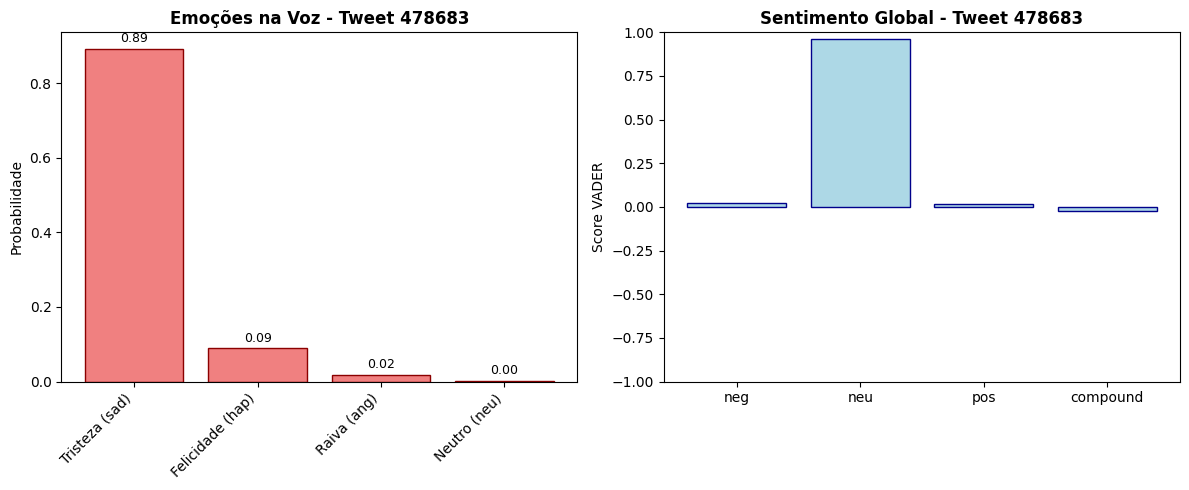

Gráfico individual salvo: resultados/grafico_1967645400300478683.png

TWEET 1967645400300478683 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/dailyprafofoca/status/1967741543944753395
 Vídeo já existe: dados/video_1967741543944753395.mp4
Áudio já existe: dados/audio_1967741543944753395.wav
Transcrição completa já existe: dados/transcricao_completa_1967741543944753395.txt
 Analisando trechos emocionais do tweet 1967741543944753395...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Você perguntou, nós setados. Eu não sei o que você... → sad, neutro
[00:04] championவ Nitrinha tão grande... → neu, neutro
[00:08] Pesticada Pai<|pt|> Compared instrumental... → neu, neutro
[00:16] E aí, falando que você dormiu na casa inteira! Pod... → hap, neutro
[00:20] Okayов... → hap, neutro
[00:24] Por causa de que vergonha que traídos...... → hap, neutro
[00:28] A fada, a fada, a senhora dela está ali na esquina... → ang, neutro
[00:32] É a que era! Por que você tá doido? Eu não me acab... → hap, neutro
[00:36] Miláfia, Miláfia! Você falirá na outra safada!... → ang, neutro
[00:40] Agora vou lá na loja dela. Ela não deu recado o sá... → hap, neutro
[00:44] Que forensic resembles digita?... → neu, neutro
[00:48] Não sabe por que, por que, por que...... → hap, neutro
[00:52] Mãe, eu falo que você seja o homem porra!... → neu, neutro
[00:56] Você seja onde? Por que você tá dormindo?... → sad, neutro
[01:00] é isso para subscribe... → ang, neutro
[01:04] Explode! Eu como est

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


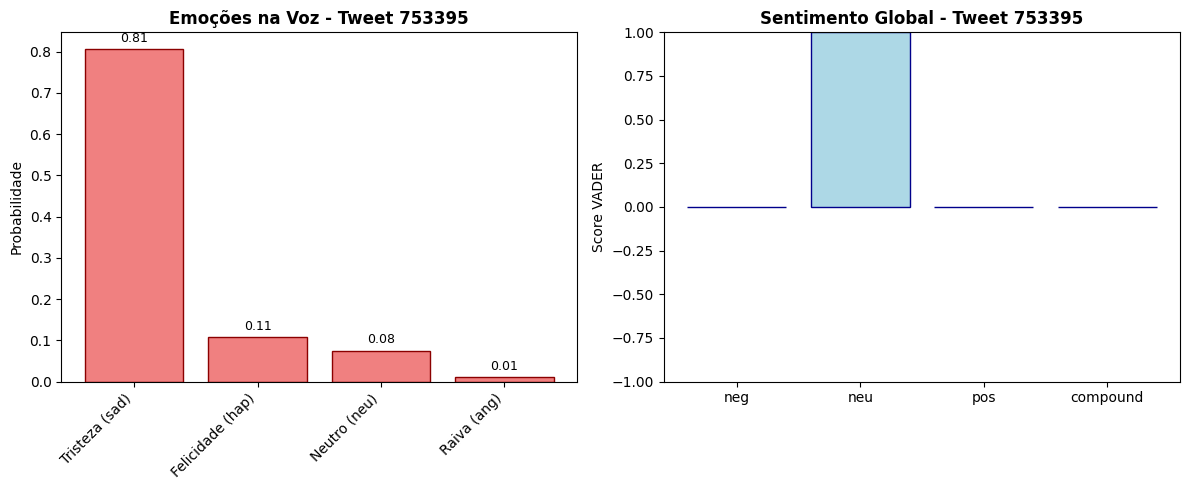

Gráfico individual salvo: resultados/grafico_1967741543944753395.png

TWEET 1967741543944753395 PROCESSADO COM SUCESSO!

PROCESSANDO: https://x.com/ironickha/status/1967589762879172852
 Vídeo já existe: dados/video_1967589762879172852.mp4
Áudio já existe: dados/audio_1967589762879172852.wav
Transcrição completa já existe: dados/transcricao_completa_1967589762879172852.txt
 Analisando trechos emocionais do tweet 1967589762879172852...


/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


[00:00] Tá perdendo meu filho, porra! A senhora viu seu fi... → ang, negativo
[00:04] .рыוב�... → sad, neutro
[00:08] que ativeu agonizando, caída no chão chorando.... → sad, negativo
[00:12] Ela te viu perdendo seu filho. O que que ela falou... → ang, neutro
[00:16] senhora não ia me atender ela tá perdendo meu... → ang, neutro
[00:20] Miro, ela está perdendo meu filho!... → hap, neutro
[00:24] O que você pandea!... → hap, neutro
[00:28] Ela te viu perdendo seu filho... → neu, neutro
[00:32] O que ela falou pra senhora? Que não ia me atender... → ang, neutro
[00:36] 15 anos... → sad, neutro
[00:40] no chão do conflito dela caída agonizando... → ang, negativo
[00:44] implorando pro socorro Meu filho!... → ang, neutro
[00:48] Não mais você sopa! E o que ela fez?... → ang, neutro
[00:52] Ela saiu do constório dela, já nasceu.... → ang, neutro
[00:56] para perder o seu filho.... → ang, neutro
[01:00] De Deus aqui ó, ó, da médica...... → hap, neutro
[01:04] É o que nós declamo! Como é que 

/home/vilmar/Documents/ADA/TrabSet/dne/lib/python3.11/site-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cpu


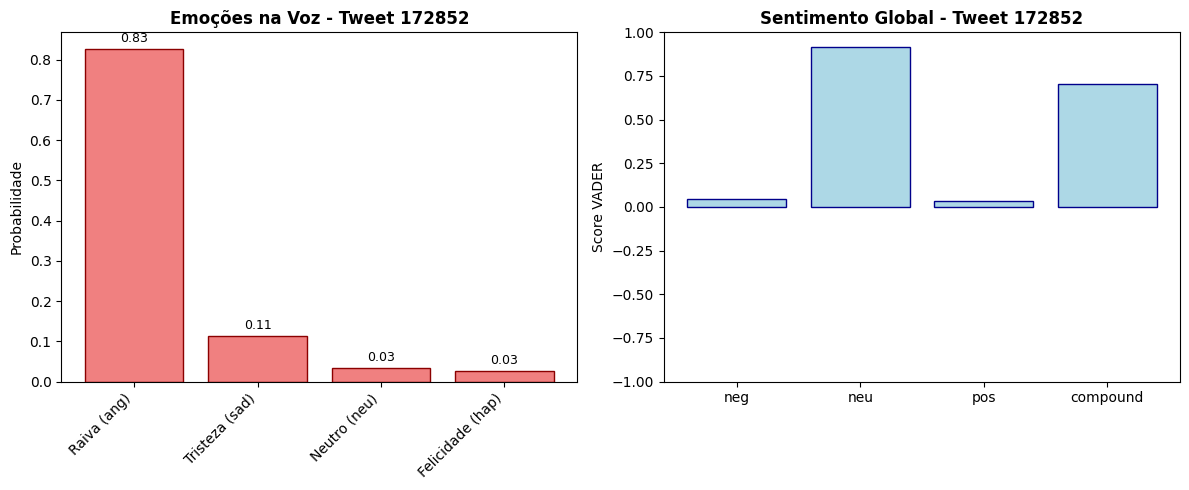

Gráfico individual salvo: resultados/grafico_1967589762879172852.png

TWEET 1967589762879172852 PROCESSADO COM SUCESSO!

RESUMO FINAL: 20/20 vídeos processados com sucesso!


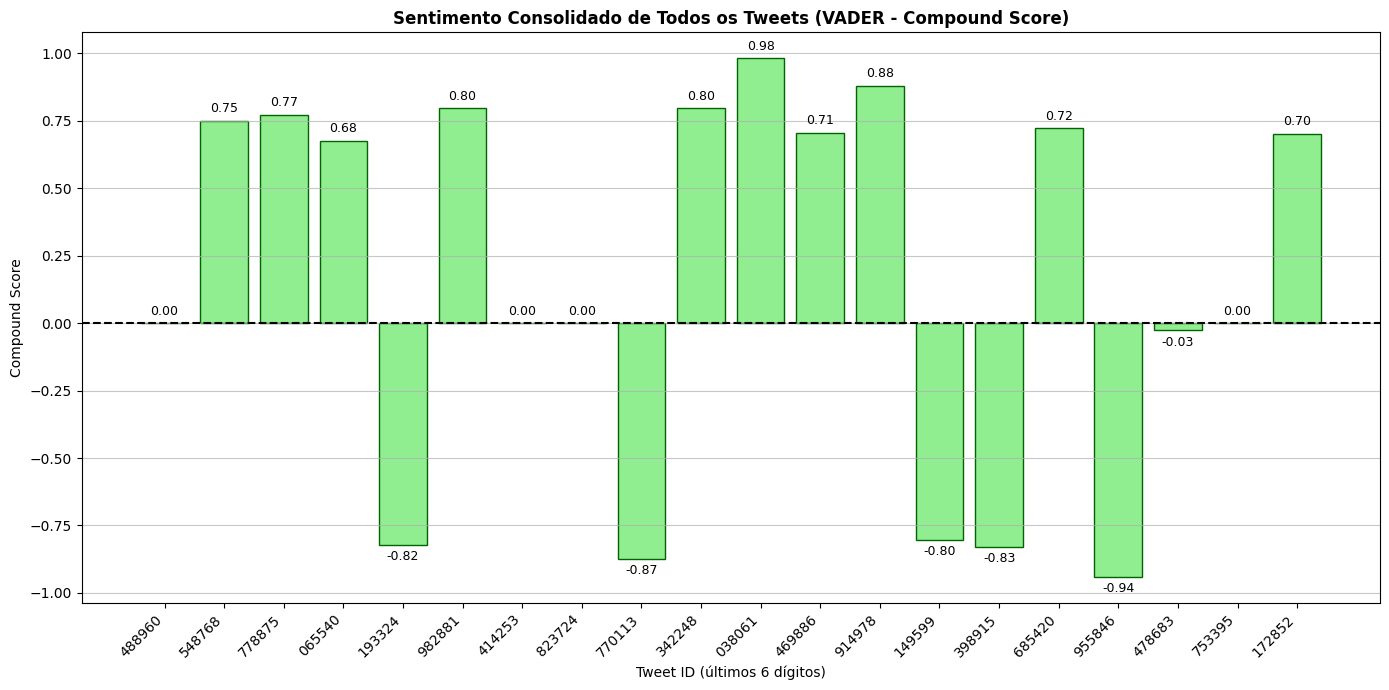

Gráfico consolidado de sentimento salvo.

DATAFRAME MASTER CONSOLIDADO SALVO EM: resultados/master_todos_trechos_consolidado.csv
Total de trechos analisados: 403
Total de tweets: 20

Amostra do DataFrame Master:


,tweet_id,timestamp,trecho,emocao_voz,sentimento_texto,observacao,neg_trecho,neu_trecho,pos_trecho,compound_trecho,neg_global,neu_global,pos_global,compound_global
0,1966548742355488960,00:00,"Eu vou ficar puta, você já é puta, vaga a puta...",hap,neutro,nenhuma observação,0.0,1.0,0.0,0.0,0.000,1.000,0.000,0.0000
1,1966548742355488960,00:04,Eu não me arrependo de ter xingado ela querend...,hap,neutro,nenhuma observação,0.0,1.0,0.0,0.0,0.000,1.000,0.000,0.0000
2,1966548742355488960,00:08,Acho que ela tem que respeitar a galera que es...,hap,neutro,tom irônico/sarcástico,0.0,1.0,0.0,0.0,0.000,1.000,0.000,0.0000
3,1966548742355488960,00:12,"Não, eu não quero. Não entendi o que você tem ...",hap,neutro,nenhuma observação,0.0,1.0,0.0,0.0,0.000,1.000,0.000,0.0000
4,1967094071681548768,00:00,Cuckoo!,hap,neutro,gritou; entusiasmo,0.0,1.0,0.0,0.0,0.016,0.929,0.055,0.7506



PIPELINE CONCLUÍDO! TODOS OS RESULTADOS ESTÃO EM 'resultados/'


In [2]:
# =============================================
# EXECUÇÃO PRINCIPAL
# =============================================
if __name__ == "__main__":
    print("INICIANDO PIPELINE COMPLETO - VERSÃO 1")
    
    processar_lista_urls(ARQUIVO_URLS)
    gerar_graficos_consolidados()
    salvar_dataframe_master()
    
    print("\nPIPELINE CONCLUÍDO! TODOS OS RESULTADOS ESTÃO EM 'resultados/'")